In [1]:
# Dependencies
import tweepy, re, json, time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from twitter_config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [2]:
def AnalyzeAndPlot(target_user):
    n_results = 500
    sentiments = []
    counter = 0

    for status in tweepy.Cursor(api.user_timeline, id=target_user, tweet_mode="extended").items(n_results):
        tweet = status._json
        results = analyzer.polarity_scores(tweet["full_text"])
        compound = results['compound']
        sentiments.append({"Date": tweet["created_at"], 
                           "Compound":compound,
                           "Tweets ago" : counter})
        counter += 1
        
    sentiments_df=pd.DataFrame.from_dict(sentiments)
    
    # Create plot
    plt.clf()
    plt.scatter(y=sentiments_df["Compound"], x=sentiments_df["Tweets ago"])
    now = datetime.now()
    now = now.strftime("%Y-%m-%d %H:%M")
    plt.title(f"Sentiment Analysis of {target_user} Tweets ({now})")
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    name = target_user.replace("@", "")
    time = datetime.now().strftime("%Y-%m-%d")
    img_file = f"plots/{name}_{time}.jpg"
    plt.savefig(img_file, dpi=100, bbox_inches='tight')
    return img_file


In [3]:
def Respond():
    #set function with local api variable vs global one
    api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
    
    # Search for all mentions
    public_tweets = api.search("@PlotBot8", count=25, result_type="recent")
    
    #create a list of accounts I've already analyzed
    my_tweets = api.user_timeline("PlotBot8", count=25, result_type="recent")
    already_analyzed = []
    
    for tweet in my_tweets:
        tweet_text = tweet["text"]
        in_reply_to_status_id = tweet["in_reply_to_status_id"]
        already_analyzed.append(in_reply_to_status_id)
    

    # Loop through mentions and see if any match correct format: 
    for tweet in public_tweets['statuses']:
        tweet_text = tweet["text"]
        print(tweet_text)
        tweet_id = tweet['id']
        tweet_author = f"@{tweet['user']['screen_name']}"
        print(tweet_author)
        match = re.match('@plotbot8 examine: @[a-z0-9_]*', tweet_text.lower())
        
        #if it matches the format, and the target isn't already in "responded" list, analyze and reply
        if match:
            target_user = tweet_text.split()[2]
            if tweet_id not in already_analyzed:
                try:
                    img_file = AnalyzeAndPlot(target_user)
                    print(img_file)
                    api.update_with_media(img_file, status=f"New Tweet Analysis: {target_user} (Thanks, {tweet_author})", in_reply_to_status_id = tweet_id)
                    print("Successful response!")
                    print(" ")
                except Exception:
                    pass
                    print("Something went wrong with sending the analysis.")
            else:
                print("This was already responded to.")
                print(" ")
                                      
        #if it doesn't match, and it wasn't my own tweet, send a response with formatting instructions
        else:
            try:
                if tweet_author != "@PlotBot8":
                    api.update_status(status=f"Sorry {tweet_author}, the query was not in the proper format, please send your query in the following format: '@PlotBot8 examine: @[screen_name to be analyzed].'", in_reply_to_status_id = tweet_id)
                    print("Wrong format. Instructions sent")
                    print(" ")
                else:
                    print("That was your response tweet.")
                    print(" ")
            except:
                print("I probably already replied with format instructions.")
                print(" ")
                pass

@PlotBot8 examine: @Drake
@PlotBot8
plots/Drake_2018-04-16.jpg
Successful response!
 
Sorry @viperkittenz, the query was not in the proper format, please send your query in the following format: '… https://t.co/dRC7ovET2e
@PlotBot8
That was your response tweet.
 
New Tweet Analysis: @DrPhil (Thanks, @PlotBot8) https://t.co/4Gk54RUjFa
@PlotBot8
That was your response tweet.
 
@PlotBot8 examine: @DrPhil
@PlotBot8
This was already responded to.
 
@zulimikov @PlotBot8 @TheRock Nice 😎
@viperkittenz
I probably already replied with format instructions.
 
New Tweet Analysis: @SFBARTalert (Thanks, @PlotBot8) https://t.co/IYZojFDfqY
@PlotBot8
That was your response tweet.
 
@PlotBot8 examine @SFBARTalert
@PlotBot8
That was your response tweet.
 
Sorry @zulimikov, the query was not in the proper format, please send your query in the following format: '… https://t.co/QF6wdKJhDL
@PlotBot8
That was your response tweet.
 


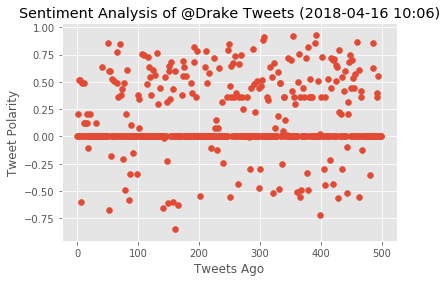

In [5]:
#Set timer to run every minute
#while(True):
Respond()
    #time.sleep(60*5)